In [ ]:
#Source: https://www.youtube.com/watch?v=VMj-3S1tku0

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# Background

In [28]:
def f(x):
    return 3*x**2 - 4*x +5

In [4]:
f(3.0)

20.0

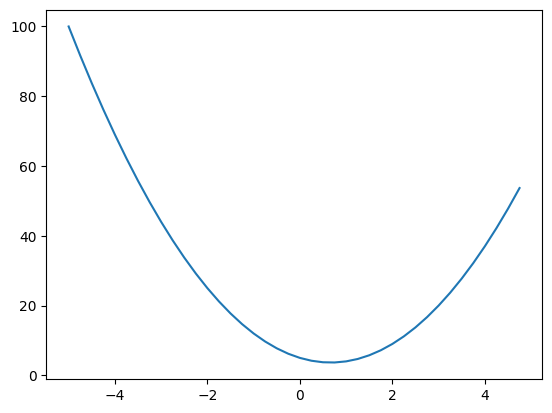

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [12]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [13]:
# Multiple Inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [16]:
h = 0.00000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# Derivative wrt c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.000000010000001
slope 1.000000082740371


# Value Object

In [36]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # prints out nicer looking function
    def __repr__(self): 
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
            
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad

        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):  # called in case of other * self
        return self * other
    
    def __truediv__(self, other):  # called for self / other
        return self * other**-1
    
    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward

        return out
    
    def backward(self):

        # Topological Sort to order graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
    
    

In [6]:
# Manual Example

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

L.grad = 1.0
f.grad = 4
d.grad = -2
e.grad = -2
c.grad = -2
b.grad = -4
a.grad = 6

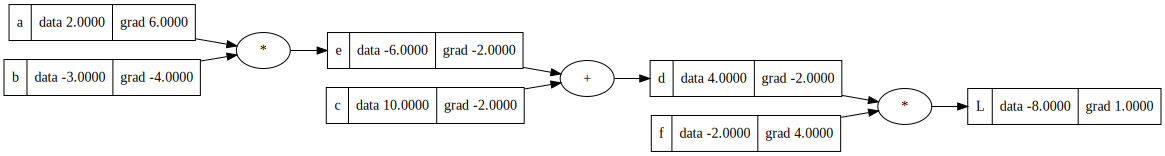

In [7]:
draw_dot(L)

In [8]:
def manual_check():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

manual_check()

0.0


# Neuron

In [9]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'

In [10]:
# Manual
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - tanh**2
# n.grad = 1-o.data**2

# b.grad = 0.5
# x1w1x2w2.grad = 0.5

# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# Calling backward for each node instead of manually
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward() # Leaf Node, nothing happens
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

#Fully Implemented
o.backward()

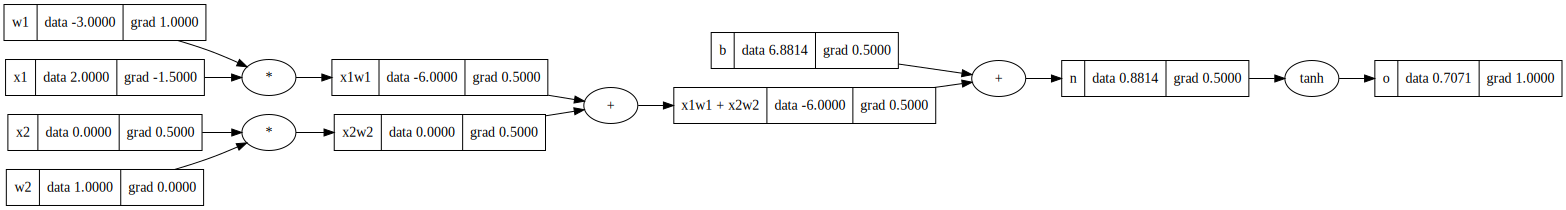

In [11]:
draw_dot(o)

## Breaking up tanh

In [12]:

#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----

o.label='o'
o.backward()

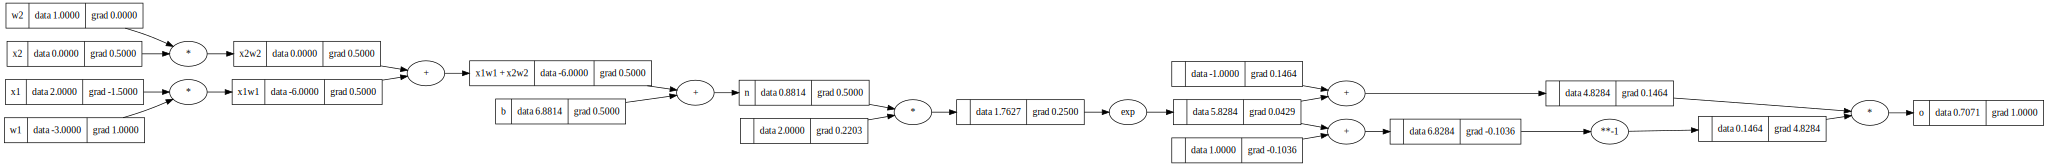

In [13]:
draw_dot(o)

# PyTorch Version

In [14]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('---')
print('x2', x2.grad)
print('w2', w2.grad)
print('x1', x1.grad)
print('w1', w1.grad)


0.7071066904050358
---
x2 tensor([0.5000], dtype=torch.float64)
w2 tensor([0.], dtype=torch.float64)
x1 tensor([-1.5000], dtype=torch.float64)
w1 tensor([1.0000], dtype=torch.float64)


# 2-layer Multilayer Perceptron

In [53]:

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):  # Forward pass
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [78]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7314010558136498)

# Using a sample dataset

In [79]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.7314010558136498),
 Value(data=0.844488541603674),
 Value(data=0.22281829380203333),
 Value(data=0.5861090628219993)]

In [80]:
# MSE Loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.14087366046027)

In [123]:
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print("Current Loss:", loss.data)
print("Current Predictions:", [y.data for y in ypred])

Current Loss: 0.012241290161593685
Current Predictions: [0.9110507638865083, -0.9968369672012238, -0.9874669472017062, 0.9354845648895628]


In [131]:
# Reinitialize

# n = MLP(3, [4, 4, 1])
# n(x)

# Putting training into a loop
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.012528811693874577
1 0.012196882734705383
2 0.011881734292596457
3 0.011582136877867433
4 0.011296977603047131
5 0.011025246729507021
6 0.010766026029988012
7 0.010518478687910341
8 0.010281840502255066
9 0.010055412205667516
10 0.009838552735102507
11 0.009630673320263967
12 0.009431232276409829
13 0.009239730405699675
14 0.009055706925853559
15 0.008878735857033753
16 0.008708422807999822
17 0.00854440211108677
18 0.00838633426270129
19 0.008233903632059485


In [132]:
ypred

[Value(data=0.9787903207151603),
 Value(data=-0.9732883473326188),
 Value(data=-0.9323859510567236),
 Value(data=0.95001118991247)]

# Exercies

## Derivatives

In [19]:
def f(a, b, c):
    return -a**3 + math.sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [20]:
# Calculus-based derivative
def gradf(a, b, c):
    dfda = -3*a**2 - 0.5*a**-0.5
    dfdb = 3*math.cos(3*b) + 2.5*b**1.5
    dfdc = c**-2
    return [dfda, dfdb, dfdc]

ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)

# Check
for dim in range(3):
    ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [21]:
# Numerical approximation of derivative
def numericalgradf(a, b, c):
    h = 0.000001

    dfda = (f(a + h, b, c) - f(a, b, c)) / h
    dfdb = (f(a, b + h, c) - f(a, b, c)) / h
    dfdc = (f(a, b, c + h) - f(a, b, c)) / h
    return [dfda, dfdb, dfdc]

a = 2
b = 3
c = 4
# -----------
numerical_grad = numericalgradf(a, b, c)
# -----------

for dim in range(3):
    ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534


In [22]:
def alt_numericalgradf(a, b, c):
    h = 0.000001

    dfda = (f(a + h, b, c) - f(a - h, b, c)) / (2*h)
    dfdb = (f(a, b + h, c) - f(a, b - h, c)) / (2*h)
    dfdc = (f(a, b, c + h) - f(a, b, c - h)) / (2*h)
    return [dfda, dfdb, dfdc]

a = 2
b = 3
c = 4

# -----------
numerical_grad2 = alt_numericalgradf(a, b, c)
# -----------

for dim in range(3):
    ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")

OK for dim 0: expected -12.353553390593273, yours returns -12.353553391353245
OK for dim 1: expected 10.25699027111255, yours returns 10.256990273571631
OK for dim 2: expected 0.0625, yours returns 0.06250000028629188


## Softmax

In [23]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
        
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1
    
    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        other = other if isinstance(other, (int, float)) else other.data
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other) * self.data**(other - 1) * out.grad
        
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def log(self):
        x = self.data
        out = Value(math.log(self.data), (self, ), 'log')

        def _backward():
            self.grad += x**-1 * out.grad

        out._backward = _backward

        return out
    
    def backward(self): # exactly as in video  
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                      build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [24]:
def softmax(logits):
    counts = [logit.exp() for logit in logits]

    denominator = sum(counts)
    out = [c / denominator for c in counts]
    return out


logits = [Value(0.0, label='x1'), Value(3.0, label='x2'), Value(-2.0, label='x3'), Value(1.0, label='x4')]
probs = softmax(logits)
loss = -probs[3].log()
loss.backward()


ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
    ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")

OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986
